In [1]:
%load_ext autoreload
%autoreload 2

import function_list
from pimp import *

In [27]:
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv", parse_dates=["date"])
oil = pd.read_csv("oil.csv", parse_dates=["date"])
holidays = pd.read_csv("holidays_events.csv", parse_dates=["date"])

In [30]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [6]:
train["date"].min(), train["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

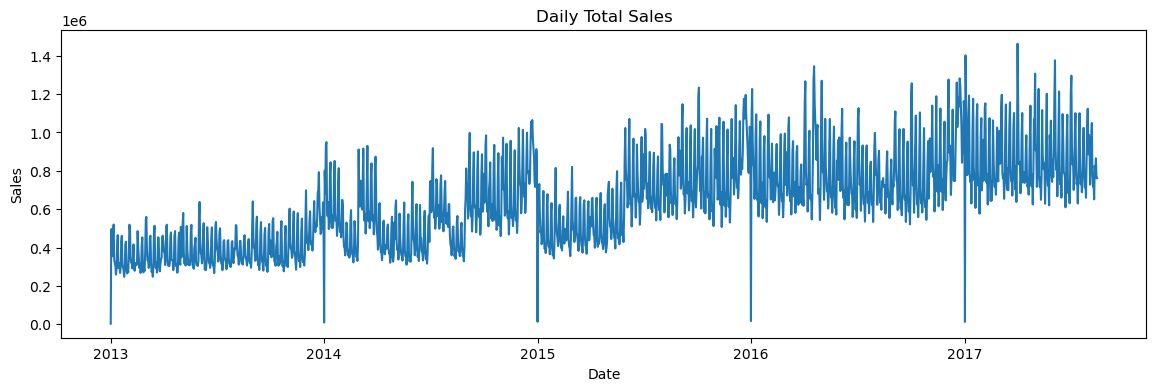

In [7]:
# 日次売り上げのトレンド
daily = train.groupby("date")["sales"].sum()

plt.figure(figsize=(14,4))
plt.plot(daily.index, daily.values)
plt.title("Daily Total Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

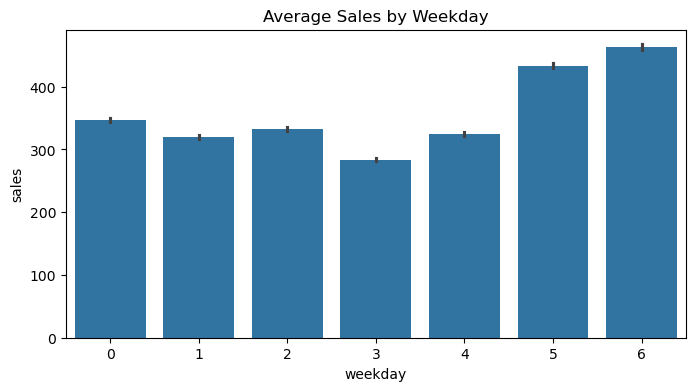

<Axes: xlabel='month', ylabel='sales'>

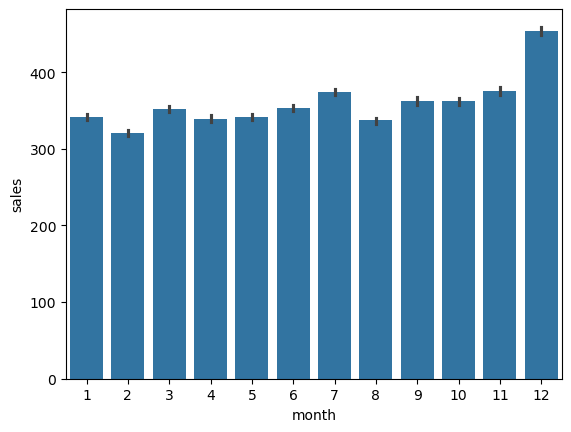

In [8]:
# 曜日ごとの平均売上（季節性）
train["weekday"] = train["date"].dt.dayofweek

plt.figure(figsize=(8,4))
sns.barplot(x="weekday", y="sales", data=train)
plt.title("Average Sales by Weekday")
plt.show()

train["month"] = train["date"].dt.month
sns.barplot(x="month", y="sales", data=train)


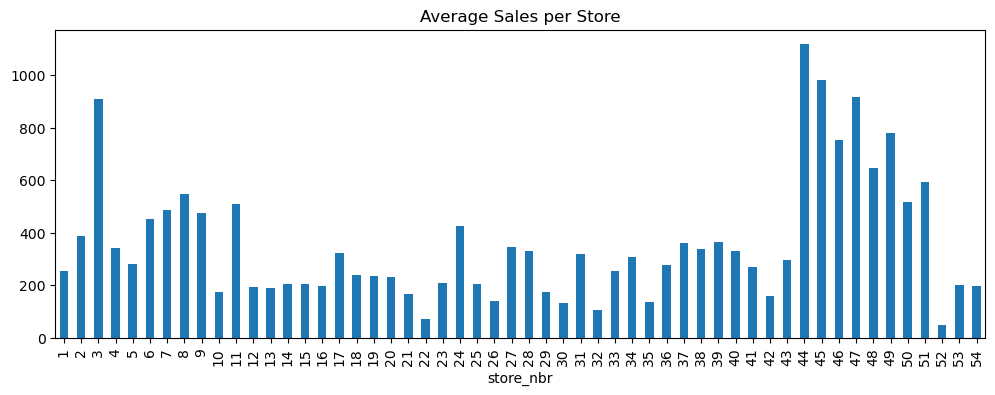

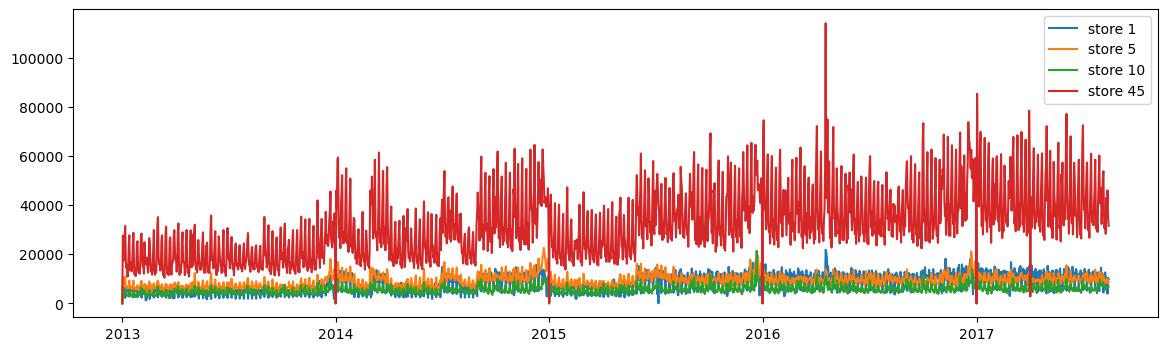

In [9]:
# 店舗ごとの平均売上
store_sales = train.groupby("store_nbr")["sales"].mean()

plt.figure(figsize=(12,4))
store_sales.plot(kind="bar")
plt.title("Average Sales per Store")
plt.show()

plt.figure(figsize=(14,4))
for store in [1, 5, 10, 45]:
    s = train[train.store_nbr == store].groupby("date")["sales"].sum()
    plt.plot(s.index, s.values, label=f"store {store}")
plt.legend()
plt.show()

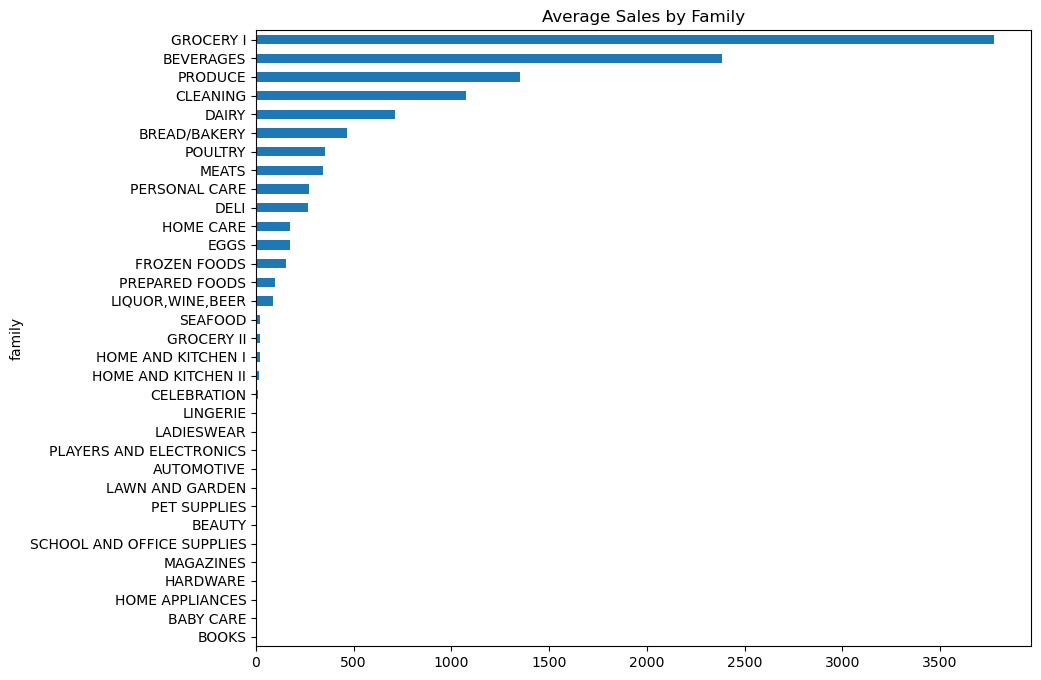

In [10]:
# family別の売上（商品カテゴリのこと）
family_sales = train.groupby("family")["sales"].mean().sort_values()

plt.figure(figsize=(10,8))
family_sales.plot(kind="barh")
plt.title("Average Sales by Family")
plt.show()


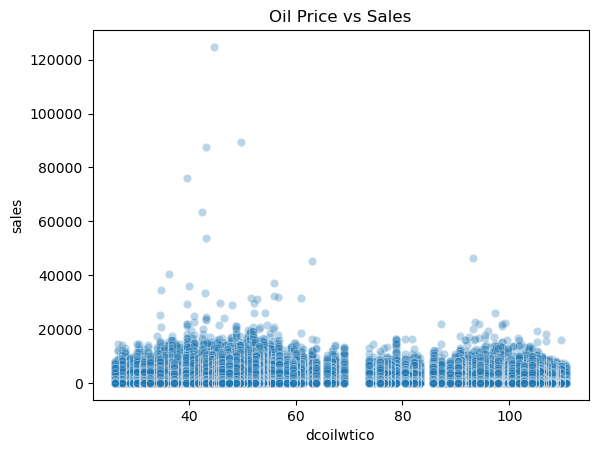

In [11]:
# 外生変数の関係
merged = train.merge(oil, on="date", how="left")

sns.scatterplot(data=merged, x="dcoilwtico", y="sales", alpha=0.3)
plt.title("Oil Price vs Sales")
plt.show()

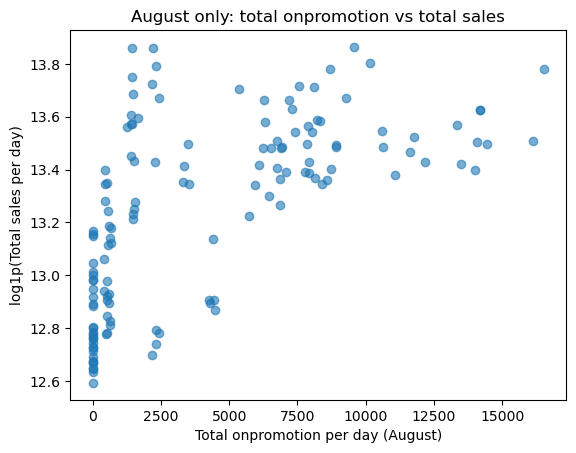

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 読み込み
train = pd.read_csv("train.csv", parse_dates=["date"])

# 8月だけ抽出
aug = train[train["date"].dt.month == 8]

# 日付ごとに全体集約
daily_aug = (
    aug
    .groupby("date")
    .agg(
        # salesカラムを合計する
        total_sales=("sales", "sum"),
        
        # onpromotionカラムを合計する
        total_onpromotion=("onpromotion", "sum")
    )
    .reset_index()
)

# log変換（可視化用）
daily_aug["log1p_sales"] = np.log1p(daily_aug["total_sales"])

# 散布図
plt.figure()
plt.scatter(
    daily_aug["total_onpromotion"],
    daily_aug["log1p_sales"],
    alpha=0.6
)
plt.xlabel("Total onpromotion per day (August)")
plt.ylabel("log1p(Total sales per day)")
plt.title("August only: total onpromotion vs total sales")
plt.show()


(1) 全体的に右上がりなので、長期トレンドがある。よって、トレンドを学習するモデルを使う必要がある（LightGBM, XGBoost, SARIMAXなど）
・季節性+トレンドの複合系列
・testデータの日付が８月後半だから、近い日付の8月前半で交差検証するべき
・７月から８月にかけて、売り上げが下がる周期性がある。つまり、季節性特徴量(month/day_of_week/複数lag)を必ず入れるべき
・特売日の売り上げにspikesがあるから、急上昇を学習できるモデル（GBDT系）が強い。

（２）金曜、土曜、日曜に売り上げが跳ね上がることから、強い週次季節性がある。
barplotは曜日ごとの”平均”の値なので、曜日ごとに明確に差があることが分かる。
つまり、曜日自体が、強い特徴量になる。

（３）店ごとに売り上げ水準が全然違うので、店の名前が強力な特徴量になる。
店舗ごとに、季節性が違う可能性があるので、グラフ化してみると、store45のように、急上昇火が多く、普段から売り上げが上下している店舗もあれば、storeのように、横ばいの店も多い。つまり、全店舗を同じモデルで学習すると、両者の中間的な挙動を学習してしまう。よって、LightGBmなら、それぞれ違う挙動として、分割してくれる。

（４）目的変数の分布が商品カテゴリで異なる→モデルは商品カテゴリを強く使うべき
つまり、カテゴリを入れないモデル（ARIMA）では絶対に無理なので、Familyが超絶特徴量になる。LightGBMならカテゴリとして学習可能。

（５）oil.csvに入っている原油価格とsalesの相関を調べてみたけど、全くない。

In [32]:
# 日次合計売上を作る
daily_sales = (
    train[train["sales"].notna()]
    .groupby("date")["sales"]
    .sum()
    .sort_index()
)

# 自己相関を計算
lags = [1, 7, 14, 21, 28]
for lag in lags:
    corr = daily_sales.corr(daily_sales.shift(lag))
    print(f"lag {lag}: {corr:.3f}")


lag 1: 0.767
lag 7: 0.826
lag 14: 0.822
lag 21: 0.774
lag 28: 0.777
